In [1]:
import torch
import botorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/Users/conniexu/opt/anaconda3/envs/baxenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

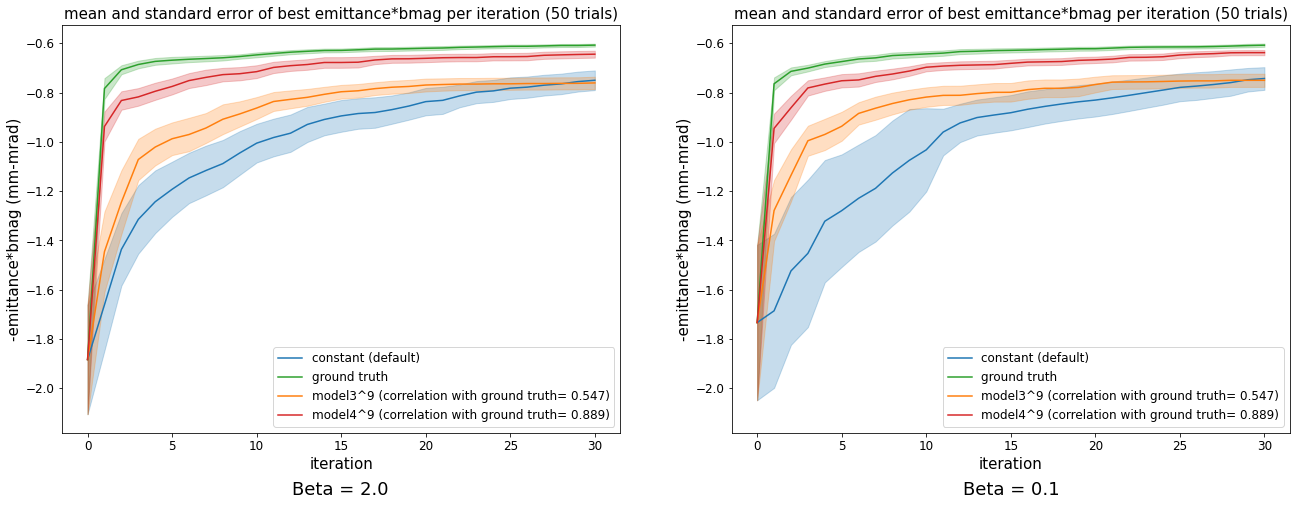

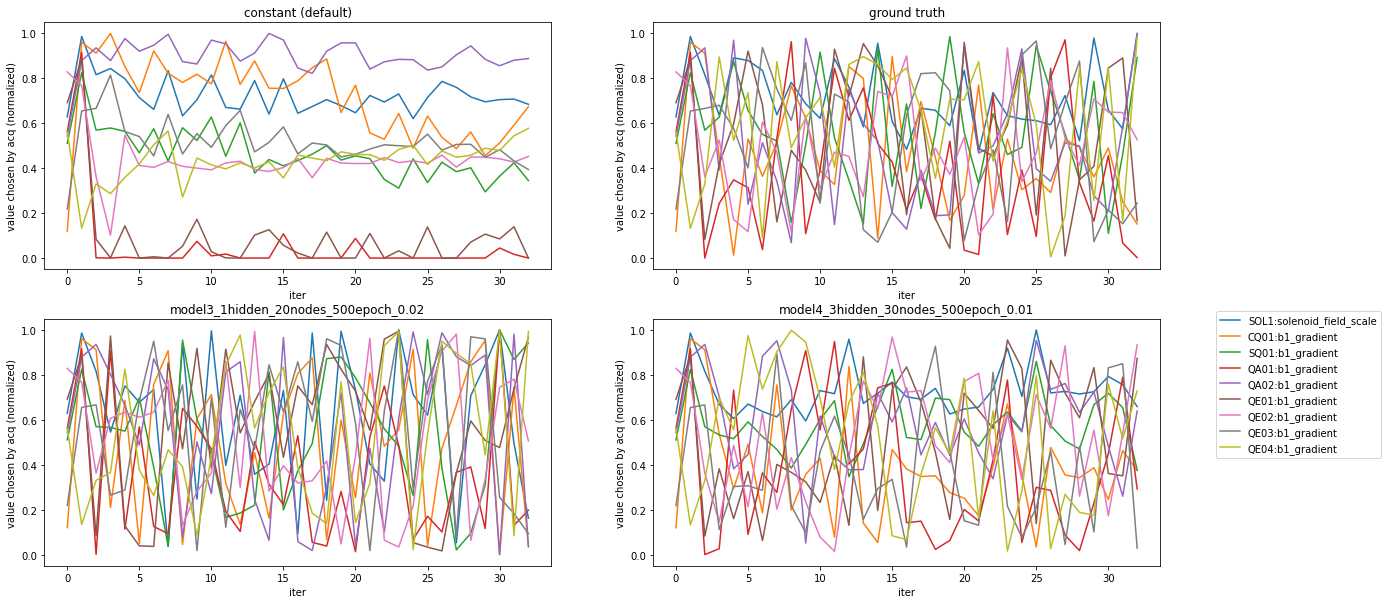

In [112]:
filenames = ['surr_const_model3_model4_2.0_ohmygoditworks', 'surr_const_model3_model4_0.1_ohmygoditworks']

# plot best_y mean and std for each BO run
fig, axes = plt.subplots(1, len(filenames), sharey=True)

colors = ['C0','C2','C1','C3','C4']
correlation = [0.547, 0.889, 0.0, 0.0] # calculated in priors_correlation_plots.ipynb  TODO: MAKE FUNCTION AND IMPORT IT IN HERE

transformer_x = botorch.models.transforms.input.Normalize(9, bounds = bounds.transpose(0,1))
for file, ax in enumerate(fig.axes):
    if file >= len(filenames):
        break
        
    BO_data_dict = torch.load('./results/'+filenames[file]+'.pt')
    x_configs = BO_data_dict['x_configs']
    best_y_lists = BO_data_dict['best_y_lists']
    # print(best_y_lists[3])
    BO_runs = BO_data_dict['BO_runs']
    for i in range(2, len(BO_runs)):
        BO_runs[i] = f'{BO_runs[i][:6]}^9 (correlation with ground truth= {correlation[i-2]})'
    run_BO = BO_data_dict['run_BO']

    n_trials = len(best_y_lists[0])
    n_steps = len(best_y_lists[0][0])
    
    ax.set_title(f'mean and standard error of best emittance*bmag per iteration ({n_trials} trials)', fontsize=15)
    x = torch.arange(n_steps)
    ax.set_xlabel('iteration', fontsize=15)
    ax.set_ylabel('-emittance*bmag (mm-mrad)', fontsize=15)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    for i in range(len(BO_runs)):
        if run_BO[i] == True:
            best_y_list = torch.stack(best_y_lists[i], dim=0)
            mean = torch.mean(best_y_list, dim=0).detach()
            # print(mean)
            std_error = torch.std(best_y_list, dim=0).detach() / torch.sqrt(torch.tensor(n_trials))
            ax.plot(x, mean, label=BO_runs[i], c = colors[i])
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
            ax.fill_between(x, mean - 2*std_error, mean + 2*std_error, alpha=0.25, color = colors[i])
            ax.yaxis.set_tick_params(which='both', labelbottom=True)
    ax.legend(loc = 'lower right', fontsize=12)
    
# fig.legend()
fig.set_size_inches(11*len(filenames), 7.5)
plt.figtext(0.27, 0.01, "Beta = 2.0", ha="left", fontsize=18)
plt.figtext(0.755, 0.01, "Beta = 0.1", ha="right", fontsize=18)
# fig.tight_layout()
fig.savefig(f'BO-plots/{filenames[0]}.png')


BO_data_dict = torch.load('./results/'+filenames[0]+'.pt')
x_configs = BO_data_dict['x_configs']
BO_runs = BO_data_dict['BO_runs']
run_BO = BO_data_dict['run_BO']

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(20, 10)

for file, ax in enumerate(fig.axes):
    if file >= len(x_configs):
        break
    
    if run_BO[file] == True:
        normed_x_config = transformer_x(x_configs[file])
        for i in range(len(opt_var_names)):
            ax.set_title(BO_runs[file])
            ax.set_xlabel('iter')
            ax.set_ylabel('value chosen by acq (normalized)')
            ax.plot(normed_x_config[:,i], label = opt_var_names[i])

plt.legend(bbox_to_anchor=(1.1, 1.05))    
fig.savefig(f'BO-plots/{filenames[0]}_scan.png')